In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

from tensorflow import keras
from tensorflow.keras import Sequential, layers

import warnings 
warnings.filterwarnings('ignore')

In [49]:
test_csv_path = '../input/test.csv'     # '/kaggle/input/nlp-getting-started/test.csv' on kaggle notebook
train_csv_path = '../input/train.csv'   # '/kaggle/input/nlp-getting-started/train.csv' on kaggle notebook

In [50]:
# look at the first hundred thousand bytes to guess the character encoding
import charset_normalizer
with open(train_csv_path, 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(1000000))
print(result)

{'encoding': 'utf-8', 'language': 'English', 'confidence': 0.9798}


In [51]:
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [53]:
df_train[['location', 'keyword']].describe()

,location,keyword
count,5080,7552
unique,3341,221
top,USA,fatalities
freq,104,45


In [54]:
df_test[['location', 'keyword']].describe()

,location,keyword
count,2158,3237
unique,1602,221
top,New York,deluged
freq,38,23


pretty less unique location in test

In [55]:
x, y = df_train.drop('target', axis=1), df_train['target']
print(x.shape, y.shape)

(7613, 4) (7613,)


In [56]:
features_num = [] # nothing!

features_cat = [
    'keyword',
    'location',
    'text',
]
#map keywords to numbers?


In [95]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.8)

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)
x_train_array = x_train.toarray()
x_test_array = x_test.toarray()
input_shape = x_train.shape[1]
print(input_shape)

9006


In [97]:
type(x_train)

scipy.sparse._csr.csr_matrix

Epoch 1/200
12/12 [==============================] - 3s 121ms/step - loss: 0.9266 - binary_accuracy: 0.5507 - val_loss: 0.6818 - val_binary_accuracy: 0.5706
Epoch 2/200
12/12 [==============================] - 1s 58ms/step - loss: 0.6084 - binary_accuracy: 0.7199 - val_loss: 0.6836 - val_binary_accuracy: 0.5706
Epoch 3/200
12/12 [==============================] - 1s 58ms/step - loss: 0.3926 - binary_accuracy: 0.8222 - val_loss: 0.6859 - val_binary_accuracy: 0.5706
Epoch 4/200
12/12 [==============================] - 1s 57ms/step - loss: 0.2708 - binary_accuracy: 0.8770 - val_loss: 0.6892 - val_binary_accuracy: 0.5706
Epoch 5/200
12/12 [==============================] - 1s 58ms/step - loss: 0.2103 - binary_accuracy: 0.9054 - val_loss: 0.6864 - val_binary_accuracy: 0.5706
Epoch 6/200
12/12 [==============================] - 1s 58ms/step - loss: 0.1819 - binary_accuracy: 0.9202 - val_loss: 0.7101 - val_binary_accuracy: 0.5706


<Axes: title={'center': 'Accuracy'}>

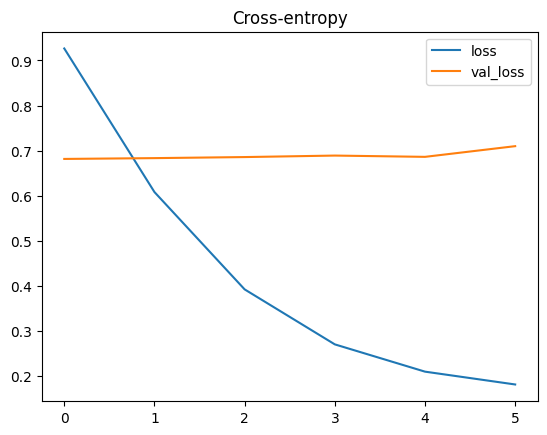

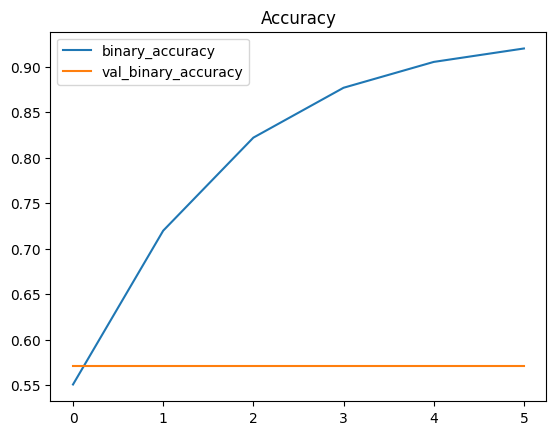

In [107]:
model = keras.Sequential()

model.add(layers.Input(shape=(input_shape,)))
model.add(layers.BatchNormalization())
    
for i in range(3):
    model.add(layers.Dropout(0.3),)
    model.add(layers.Dense(1024, activation='relu'),)
    model.add(layers.BatchNormalization(),)

model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5, 
    min_delta=0.001, 
    restore_best_weights=True,
)

history = model.fit(
    x_train_array, y_train,
    epochs=200,
    batch_size=512,
    validation_data=(x_test_array, y_test),
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")